In [28]:
import numpy as np
import pandas as pd
import polars as pl
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
import joblib
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import tqdm
import scorecardpy as sc
from sklearn.metrics import roc_auc_score


In [3]:
class Data_Pipeline:
    def data_dtypes_adj(df): # set_table_dtypes
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.Utf8))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
                
        return df

    def date_adj(df): #  handle_dates
        for col in df.columns:
            if col[-1] in ("D"):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())

        df = df.drop("date_decision", "MONTH")

        return df

    def col_filter(df): # filter_cols
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                if df[col].dtype != pl.String:
                    isnull = df[col].is_null().mean()
                    if isnull > 0.90:
                        df = df.drop(col)
                else:
                    freq = df[col].n_unique()
                    if (freq == 1) | (freq > 200):
                        df = df.drop(col)
        return df
    
    def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
        start_mem = df.memory_usage().sum() / 1024 ** 2;
        gc.collect()
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        cols = subset if subset is not None else df.columns.tolist()

        for col in cols:
            col_type = df[col].dtype

            if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
                df[col] = df[col].fillna(-888)
                c_min = df[col].min()
                c_max = df[col].max()
                treat_as_int = True
                if treat_as_int:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                    elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            elif 'datetime' not in col_type.name and obj_to_category:
                df[col] = df[col].fillna('Mis')
                df[col] = df[col].astype('category')
        gc.collect()
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df


In [4]:
class Aggregator:
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max

    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max

    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max

    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max

    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max

    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [5]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )

    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")

    df_base = df_base.pipe(Data_Pipeline.date_adj)

    return df_base

In [6]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()

    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)

    df_data[cat_cols] = df_data[cat_cols].astype("category")

    return df_data, cat_cols

In [7]:
def read_file(path, depth=None):
    df = pd.read_parquet(path)
    df = df.pipe(Data_Pipeline.reduce_mem_usage)
    df = pl.from_pandas(df)
    df = df.pipe(Data_Pipeline.data_dtypes_adj)
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.from_pandas(pd.read_parquet(path)
                                     .pipe(Data_Pipeline.reduce_mem_usage))
                                     .pipe(Data_Pipeline.data_dtypes_adj))

    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

    return df

In [ ]:
data_store_train = {
    "df_base": read_file("train_base.parquet"),
    "depth_0": [
        read_file("train_static_cb_0.parquet"),
        read_files("train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files("train_applprev_1_*.parquet", 1),
        read_file("train_tax_registry_a_1.parquet", 1),
        read_file("train_tax_registry_b_1.parquet", 1),
        read_file("train_tax_registry_c_1.parquet", 1),
        read_file("train_credit_bureau_b_1.parquet", 1),
        read_files("train_credit_bureau_a_1_*.parquet", 1),
        read_file("train_other_1.parquet", 1),
        read_file("train_person_1.parquet", 1),
        read_file("train_deposit_1.parquet", 1),
        read_file("train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file("train_credit_bureau_b_2.parquet", 2),
        read_file('train_person_2.parquet', 2),
        read_files('train_credit_bureau_a_2_*.parquet', 2),
        read_file('train_applprev_2.parquet', 2)
    ]
}

data_store_test = {
    "df_base": read_file("test_base.parquet"),
    "depth_0": [
        read_file("test_static_cb_0.parquet"),
        read_files("test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files("test_applprev_1_*.parquet", 1),
        read_file("test_tax_registry_a_1.parquet", 1),
        read_file("test_tax_registry_b_1.parquet", 1),
        read_file("test_tax_registry_c_1.parquet", 1),
        read_file("test_credit_bureau_b_1.parquet", 1),
        read_files("test_credit_bureau_a_1_*.parquet", 1),
        read_file("test_other_1.parquet", 1),
        read_file("test_person_1.parquet", 1),
        read_file("test_deposit_1.parquet", 1),
        read_file("test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file("test_credit_bureau_b_2.parquet", 2),
        read_file('test_person_2.parquet', 2),
        read_files('test_credit_bureau_a_2_*.parquet', 2),
        read_file('test_applprev_2.parquet', 2)
    ]
}

Memory usage of dataframe is 58.24 MB
Memory usage after optimization is: 26.207 MB
Decreased by 55.0%
Memory usage of dataframe is 606.73 MB
Memory usage after optimization is: 306.227 MB
Decreased by 49.5%
Memory usage of dataframe is 1279.85 MB
Memory usage after optimization is: 572.440 MB
Decreased by 55.3%
Memory usage of dataframe is 666.73 MB
Memory usage after optimization is: 300.703 MB
Decreased by 54.9%
Memory usage of dataframe is 1216.09 MB
Memory usage after optimization is: 863.867 MB
Decreased by 29.0%
Memory usage of dataframe is 825.27 MB
Memory usage after optimization is: 586.245 MB
Decreased by 29.0%
Memory usage of dataframe is 124.96 MB
Memory usage after optimization is: 78.101 MB
Decreased by 37.5%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 26.415 MB
Decreased by 37.5%
Memory usage of dataframe is 127.56 MB
Memory usage after optimization is: 79.723 MB
Decreased by 37.5%
Memory usage of dataframe is 29.45 MB
Memory usage after op

In [32]:
df_train = feature_eng(**data_store_train)
print("train data shape:\t", df_train.shape)
del data_store_train
gc.collect()

train data shape:	 (1526659, 487)


1635

In [34]:
df_test = feature_eng(**data_store_test)
print("test data shape:\t", df_test.shape)
del data_store_test
gc.collect()

test data shape:	 (10, 486)


In [37]:
df_train = df_train.pipe(Data_Pipeline.col_filter)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 403)
test data shape:	 (10, 402)


In [38]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

## Start from the following steps if already saved 3 datasets

In [6]:
# df_train = pd.read_parquet("df_train_pqt.parquet")
# df_test = pd.read_parquet("df_test_pqt.parquet")
# cat_cols = pd.read_csv('cat_cols.csv')

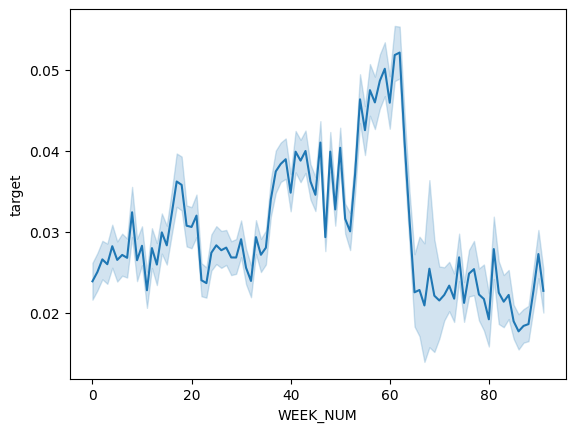

In [7]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

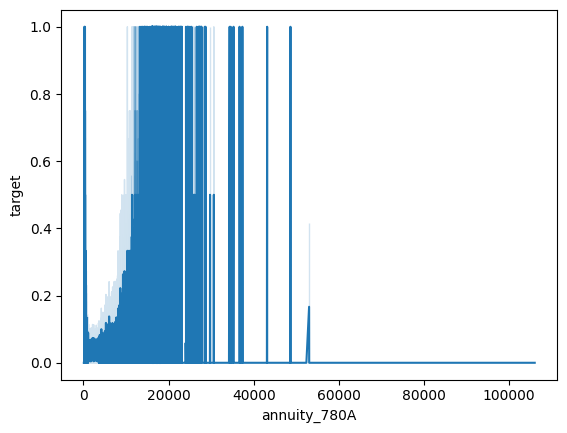

In [8]:
sns.lineplot(
    data=df_train,
    x="annuity_780A",
    y="target",
)
plt.show()

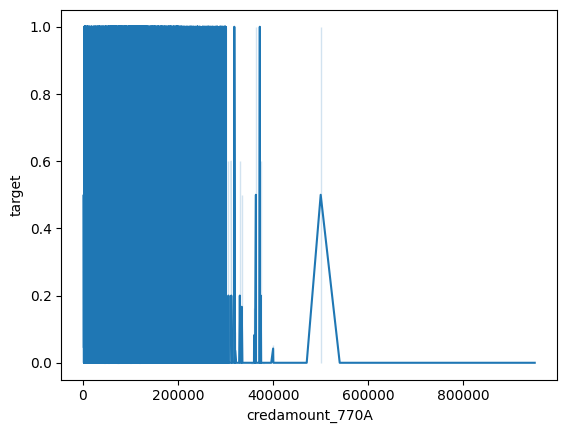

In [9]:
sns.lineplot(
    data=df_train,
    x="credamount_770A",
    y="target",
)
plt.show()

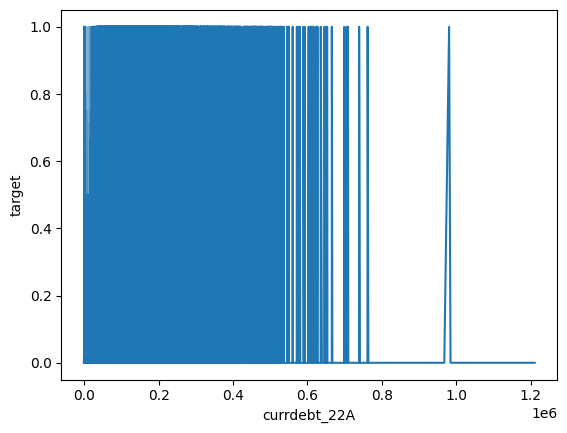

In [10]:
sns.lineplot(
    data=df_train,
    x="currdebt_22A",
    y="target",
)
plt.show()

In [18]:
# selected_columns = df_train.columns.difference(['case_id', 'date_decision',
#                                                   'MONTH','WEEK_NUM'])
# iv_info = sc.iv(df_train[selected_columns],y='target')
# (iv_info.sort_values(by = 'info_value',ascending= False)).to_pickle('ranged_iv_for_train_features.pkl')

In [11]:
iv_info = pd.read_pickle('ranged_iv_for_train_features.pkl')

In [21]:
# iv_info.sort_values(by = 'info_value',ascending= False)

,variable,info_value
313,contractssum_5085716L,2.044398
143,max_contractsum_5085717L,2.012904
64,max_totalamount_996A,1.830139
195,max_credlmt_935A,1.799406
332,max_overdueamountmax2_398A,1.737111
...,...,...
42,max_contaddr_matchlist_1032L,0.000046
271,max_addres_role_871L,0.000033
10,max_role_993L,0.000025
18,interestrategrace_34L,0.000012


In [12]:
df_train = df_train[list(iv_info[iv_info['info_value']>=0.02]['variable'])+['case_id', 'WEEK_NUM', 'target']]

In [13]:
import toad as td
from toad.metrics import PSI

In [16]:
selected_columns2 = df_train.columns.difference(['case_id', 'WEEK_NUM','target'])
PSI_map = {}
std_map = {}
for i in selected_columns2:
    PSI_value = []
    for j in range(91):
        PSI_weekly = PSI(df_train[df_train['WEEK_NUM']==j][i], 
                         df_train[df_train['WEEK_NUM']==j+1][i])
        PSI_value.append(PSI_weekly)
    PSI_map[i] = np.mean(PSI_value)
    std_map[i] = np.std(PSI_value)

In [17]:
stable_features = [key for key, value in PSI_map.items() if value <= 0.2]

In [18]:
df_train = df_train[stable_features+['case_id', 'WEEK_NUM','target']]

In [19]:
df_test = df_test[stable_features+['case_id', 'WEEK_NUM']]

In [20]:
df_train['max_isbidproduct_390L'] = df_train['max_isbidproduct_390L'].astype(bool)
df_train['opencred_647L'] = df_train['opencred_647L'].astype(bool)
df_test['max_isbidproduct_390L'] = df_test['max_isbidproduct_390L'].astype(bool)
df_test['opencred_647L'] = df_test['opencred_647L'].astype(bool)

In [21]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [23]:
from sklearn.metrics import roc_auc_score

X = df_train.drop(columns=["target", "case_id","WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.05,
    "max_bin": 255,
    "n_estimators": 1000,
    "colsample_bytree": 0.9, 
    "colsample_bynode": 0.9,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1, 
    "reg_lambda": 3.25, 
    "extra_trees":True,
    "device": "cpu",
}

fitted_models = []
cv_scores = []  

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    print("Valid week range: ", (weeks.iloc[idx_valid].min(), weeks.iloc[idx_valid].max()))

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)

model = VotingModel(fitted_models)
print("CV AUC scores: ", cv_scores)
print("Average CV AUC score: ", sum(cv_scores) / len(cv_scores))

Valid week range:  (3, 90)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.826386
[200]	valid_0's auc: 0.836135
[300]	valid_0's auc: 0.840141
[400]	valid_0's auc: 0.84223
[500]	valid_0's auc: 0.843287
[600]	valid_0's auc: 0.844016
[700]	valid_0's auc: 0.844618
[800]	valid_0's auc: 0.845001
[900]	valid_0's auc: 0.845423
[1000]	valid_0's auc: 0.845705
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.845708
Valid week range:  (0, 89)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.824711
[200]	valid_0's auc: 0.835368
[300]	valid_0's auc: 0.839535
[400]	valid_0's auc: 0.841741
[500]	valid_0's auc: 0.842887
[600]	valid_0's auc: 0.84363
[700]	valid_0's auc: 0.844073
[800]	valid_0's auc: 0.844558
[900]	valid_0's auc: 0.84487
[1000]	valid_0's auc: 0.845111
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.845123
Valid week range:  (2, 91)
Training until validation scores don't i

In [29]:
import xgboost as xgb
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
fitted_models = []
cv_scores = []
X = df_train.drop(columns=["target", "case_id","WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
params = {
    "device": "cpu",  
    "objective": "binary:logistic",
    "tree_method": "hist",  
    "enable_categorical": True,
    "eval_metric": "auc",
    "subsample": 0.8,  
    "colsample_bytree": 0.8,  
    "min_child_weight": 10,  
    "max_depth": 10,  
    "n_estimators": 1000,  
    "learning_rate": 0.01,  
    "random_state": 42,
}

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    print("Valid week range: ", (weeks.iloc[idx_valid].min(), weeks.iloc[idx_valid].max()))
    
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50, 
        verbose=10, 
    )
    fitted_models.append(xgb_model)
    y_pred_valid = xgb_model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    print(f"Validation AUC for this fold: {auc_score}")
    
average_auc = sum(cv_scores) / len(cv_scores)
print(f"Average CV AUC: {average_auc}")

Valid week range:  (3, 90)
[13:06:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.75898
[10]	validation_0-auc:0.78846
[20]	validation_0-auc:0.78895
[30]	validation_0-auc:0.79006
[40]	validation_0-auc:0.79149
[50]	validation_0-auc:0.79357
[60]	validation_0-auc:0.79500
[70]	validation_0-auc:0.79605
[80]	validation_0-auc:0.79696
[90]	validation_0-auc:0.79799
[100]	validation_0-auc:0.79921
[110]	validation_0-auc:0.80051
[120]	validation_0-auc:0.80169
[130]	validation_0-auc:0.80238
[140]	validation_0-auc:0.80316
[150]	validation_0-auc:0.80399
[160]	validation_0-auc:0.80470
[170]

Validation AUC for this fold: 0.7920475258691314
Valid week range:  (5, 88)
[13:16:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.76082
[10]	validation_0-auc:0.78395
[20]	validation_0-auc:0.78678
[30]	validation_0-auc:0.78935
[40]	validation_0-auc:0.78745
[50]	validation_0-auc:0.78806
[60]	validation_0-auc:0.78931
[70]	validation_0-auc:0.79174
[80]	validation_0-auc:0.79029
[90]	validation_0-auc:0.79227
[100]	validation_0-auc:0.79319
[110]	validation_0-auc:0.79515
[120]	validation_0-auc:0.79455
[130]	validation_0-auc:0.79611
[140]	validation_0-auc:0.79754
[150]	validation_0

In [44]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")
X_test['max_empl_employedtotal_800L'] = X_test['max_empl_employedtotal_800L'].astype('category')
lgb_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

In [45]:
df_subm = pd.read_csv("sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = lgb_pred

In [46]:
df_subm.to_csv("submission.csv")